# lab4: working with 'real' data

In [108]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,8)

In [109]:
# import the file for problem1
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys() # different kinds of data sets
# import data into array variable
data = np.array(hf.get('data'))
# print the first row of more than 25 million data records
data[:,0]
#close the file
hf.close()

# problem1

4 columns: time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. 

1.1 make a few plots and general exploration

1.2 high level description of the data features

1.3 comment on whether see the signal contamination in the data, and how you plan to build a background pdf()

We fist explore the respective relationships between each other column with the time, and only consider the first 500k data.

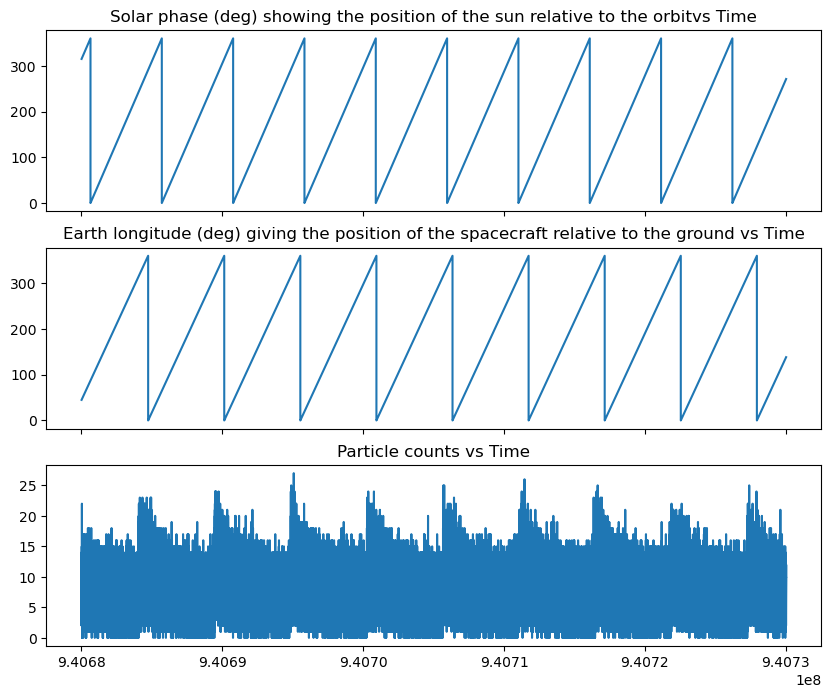

In [110]:
num = 500000
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True)
ax1.plot(data[0,:num], data[1,:num])
ax1.set_title('Solar phase (deg) showing the position of the sun relative to the orbitvs Time')
ax2.plot(data[0,:num], data[2,:num])
ax2.set_title('Earth longitude (deg) giving the position of the spacecraft relative to the ground vs Time')
ax3.plot(data[0,:num], data[3,:num])
ax3.set_title('Particle counts vs Time')
plt.show()

From the series of plots above, we find that these three graphs all periodic. Compared with the relatively chaotic third plot, the first two plots are both linear with time and with some phase shift between these two plots. 

Then, we will have a more careful consideration of the particle counts. Let's start with the first 10k data. 

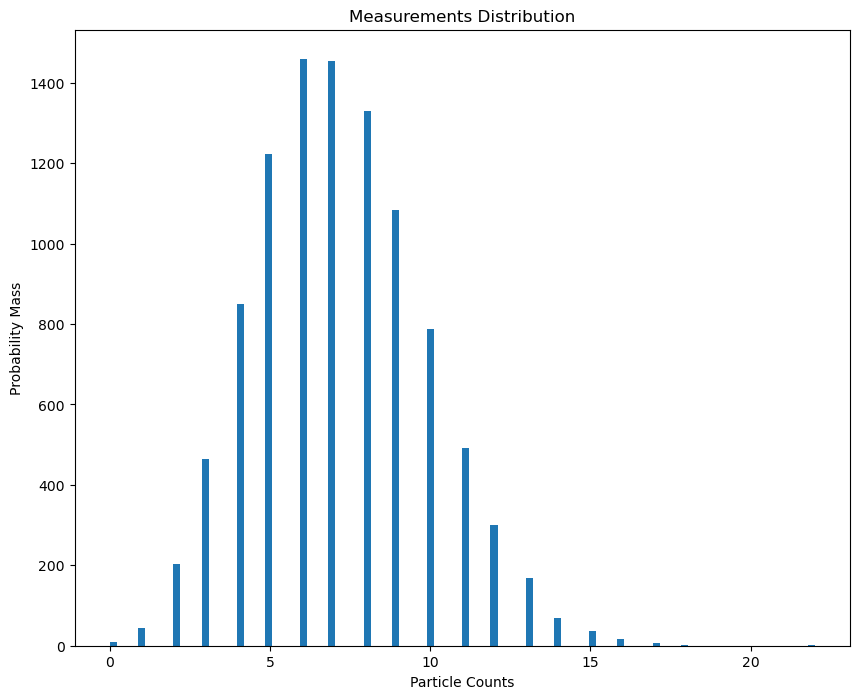

In [111]:
plt.hist(data[3][0:10000],bins=100);
plt.title('Measurements Distribution')
plt.xlabel('Particle Counts')
plt.ylabel('Probability Mass')
plt.show()

From the plot above, we can find that this is a discrete distribution, and we want to give assumption that it is the Poisson Distribution. Then, we will check whether it is actual the Poisson Distribution. 

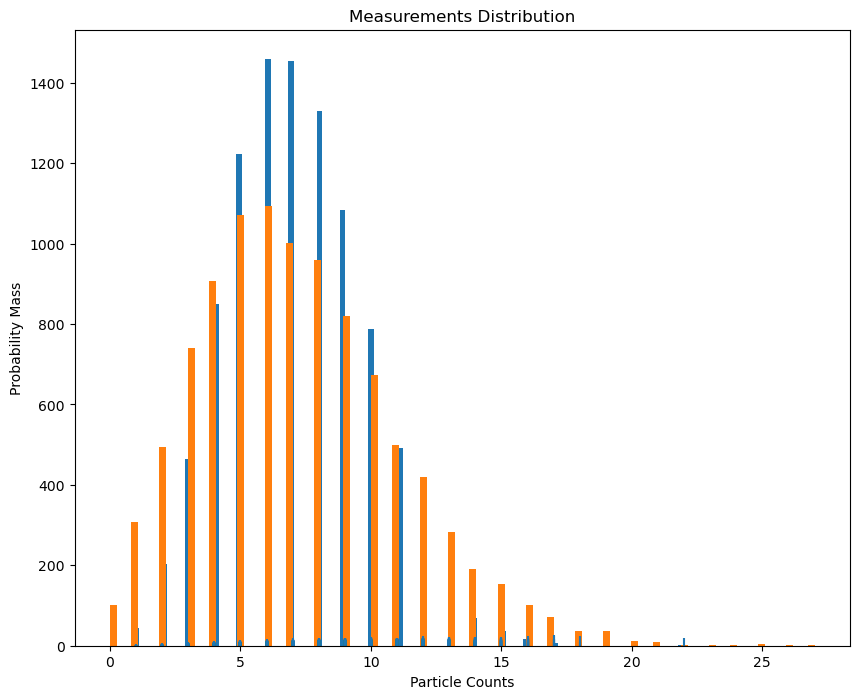

In [112]:
counts = data[3][0:10000]
plt.hist(counts,bins=100);
plt.hist(stats.poisson(counts).rvs(len(counts)),bins=100)
plt.vlines(counts,0, stats.poisson(counts).rvs(len(counts)))
plt.title('Measurements Distribution')
plt.xlabel('Particle Counts')
plt.ylabel('Probability Mass')
plt.show()

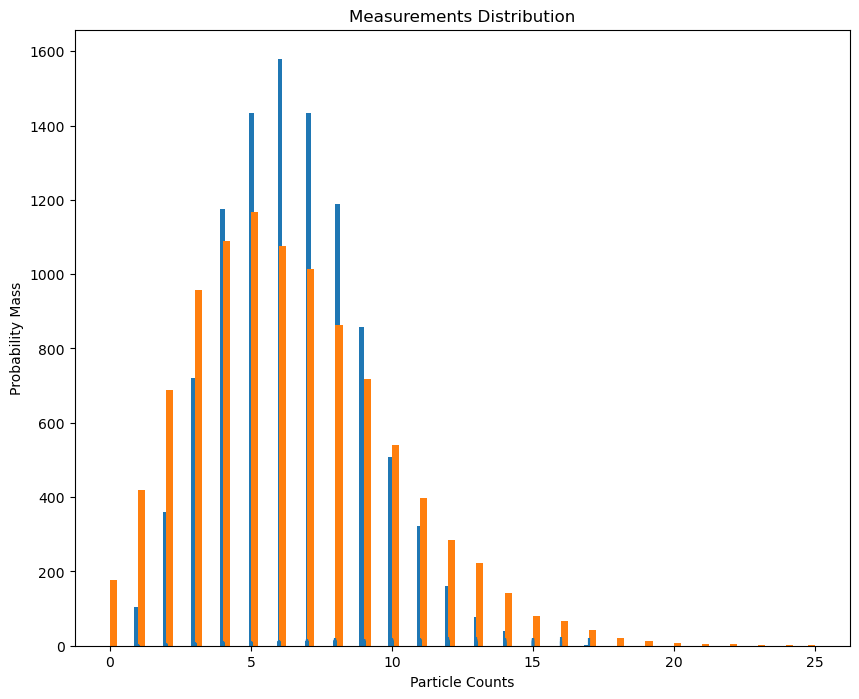

In [113]:
counts = data[3][10000:20000]
plt.hist(counts,bins=100);
plt.hist(stats.poisson(counts).rvs(len(counts)),bins=100)
plt.vlines(counts,0, stats.poisson(counts).rvs(len(counts)))
plt.title('Measurements Distribution')
plt.xlabel('Particle Counts')
plt.ylabel('Probability Mass')
plt.show()

We find from the plot above, the blue histograms are actual the particle counts, and the orange histograms are the data from real Poisson Distribution. We find the shape is actual similar, but just wil some slihgt difference. 

Then, we will continue the relationship between other two columns.

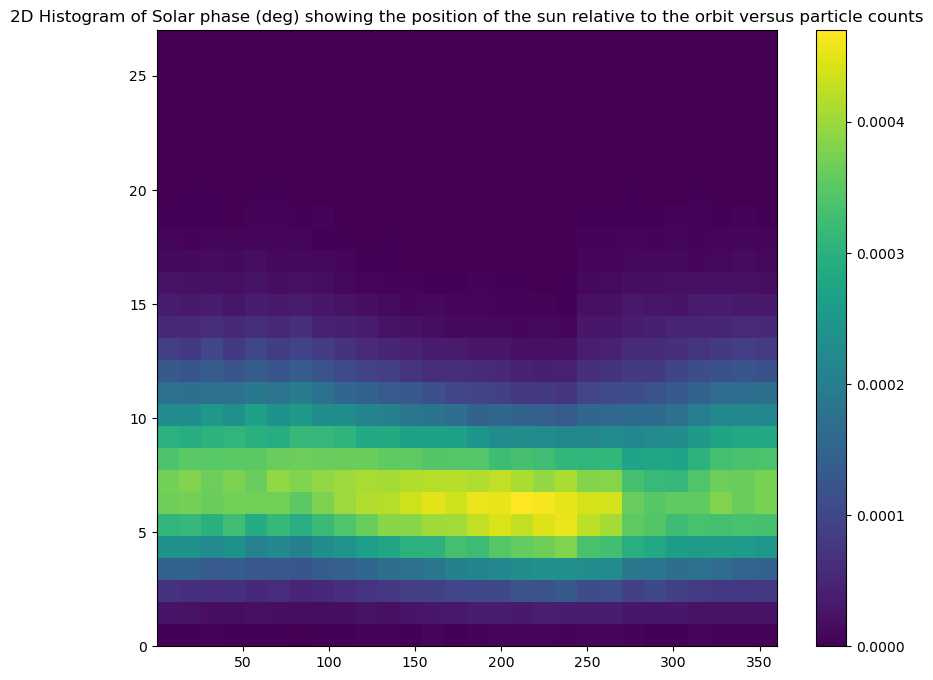

In [114]:
# make a 2d histogram of the second and fourth coloum
h = plt.hist2d(data[1,:num], data[3,:num], bins=(28,28), density=True);
plt.title("2D Histogram of Solar phase (deg) showing the position of the sun relative to the orbit versus particle counts")
plt.colorbar()
plt.show()

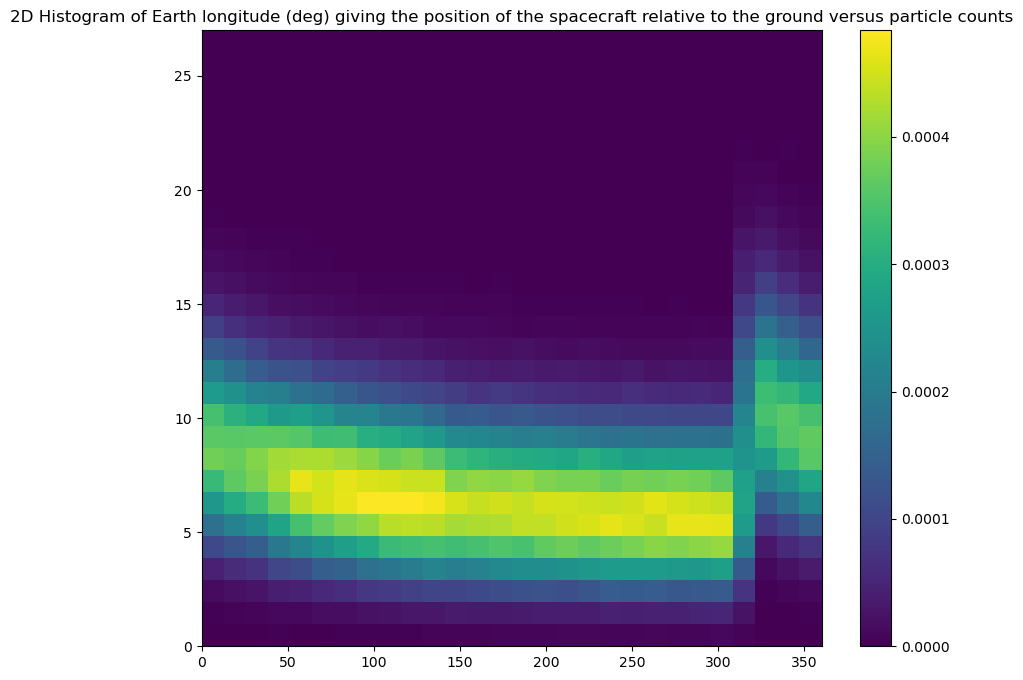

In [115]:
# make a 2d histogram of the third and fourth coloum
h = plt.hist2d(data[2,:num], data[3,:num], bins=(28,28), density=True);
plt.title("2D Histogram of Earth longitude (deg) giving the position of the spacecraft relative to the ground versus particle counts")
plt.colorbar()
plt.show()

Compared with these two 2D histogram, we find that that there is a brust jump around the 310 degrees. This histogram shows how the background changes with the orbital phase. And this is the longitude affecting the background. Then, we will continue to study the more detailed relationship between the distribution and the longitude. We want to find out what exactly the degree is. 

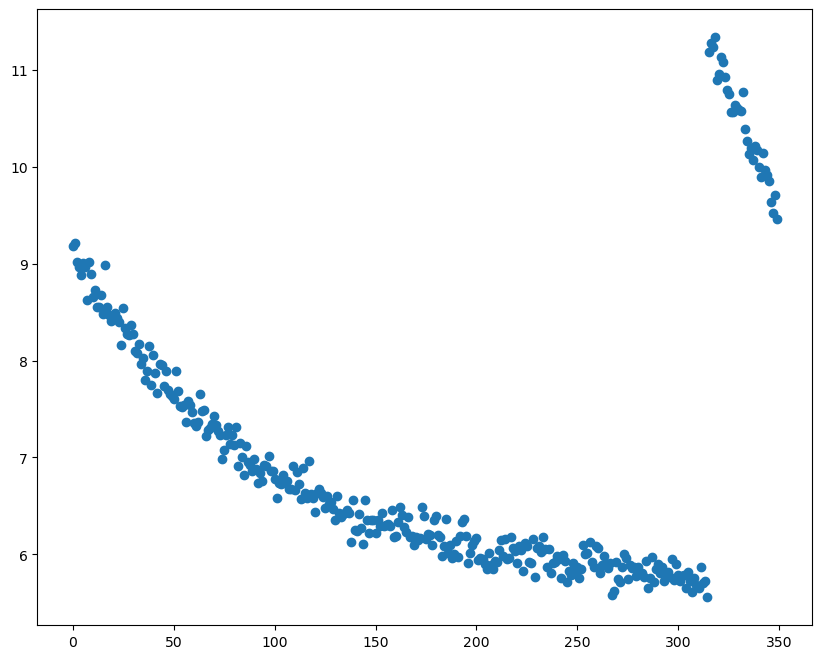

In [116]:
counts = data[3]
meanValues = []
for i in np.arange(350):
    mean = np.mean(counts[data[2]==i])
    meanValues.append(mean)
plt.scatter(np.arange(350), meanValues)
plt.show()

Few more trials, try some specific values around 310.

In [117]:
meanValues[310:320]

[5.654166666666667,
 5.86875,
 5.708333333333333,
 5.725,
 5.55625,
 11.183333333333334,
 11.283333333333333,
 11.24375,
 11.339583333333334,
 10.895833333333334]

We find that there is a big brust between 314 and 315, and the mean value is from 5.556 to 11.18 particles.

part 4) study the '5-sigma' threshold for a 100 millisecond

In [118]:
five_sig = stats.norm.sf(5)
min_sig = stats.poisson.isf(stats.norm.sf(5), meanValues[np.argmin(meanValues)])
min_sig

21.0

In [119]:
max_sig = stats.poisson.isf(stats.norm.sf(5), meanValues[np.argmax(meanValues)])
max_sig

32.0

Now, we find out that the minimun signal is 21, and the maximun signal is 32. Then, the range of the signal is from 21 to 32.

# problem2

goal: looking for the faintest stars among ten images

part 1) download the data

In [120]:
hf2 = h5py.File('images.h5', 'r')

In [121]:
hf2.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [122]:
#get access to the data
image1_data = np.array(hf2.get('image1'))
imagestack_data = np.array(hf2.get('imagestack'))

In [123]:
hf2.close()

part 2) explore the data

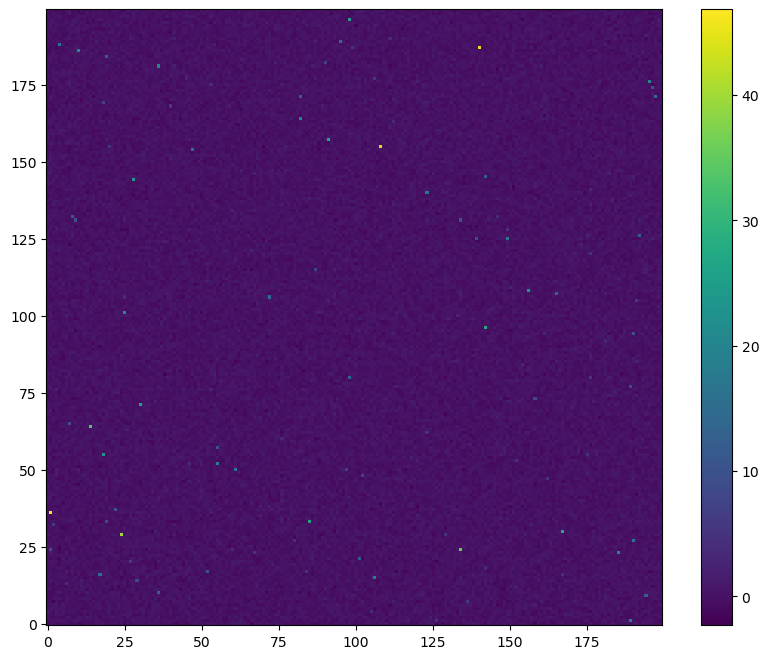

In [124]:
#plot the image1
plt.imshow(image1_data, origin='lower')
plt.colorbar()

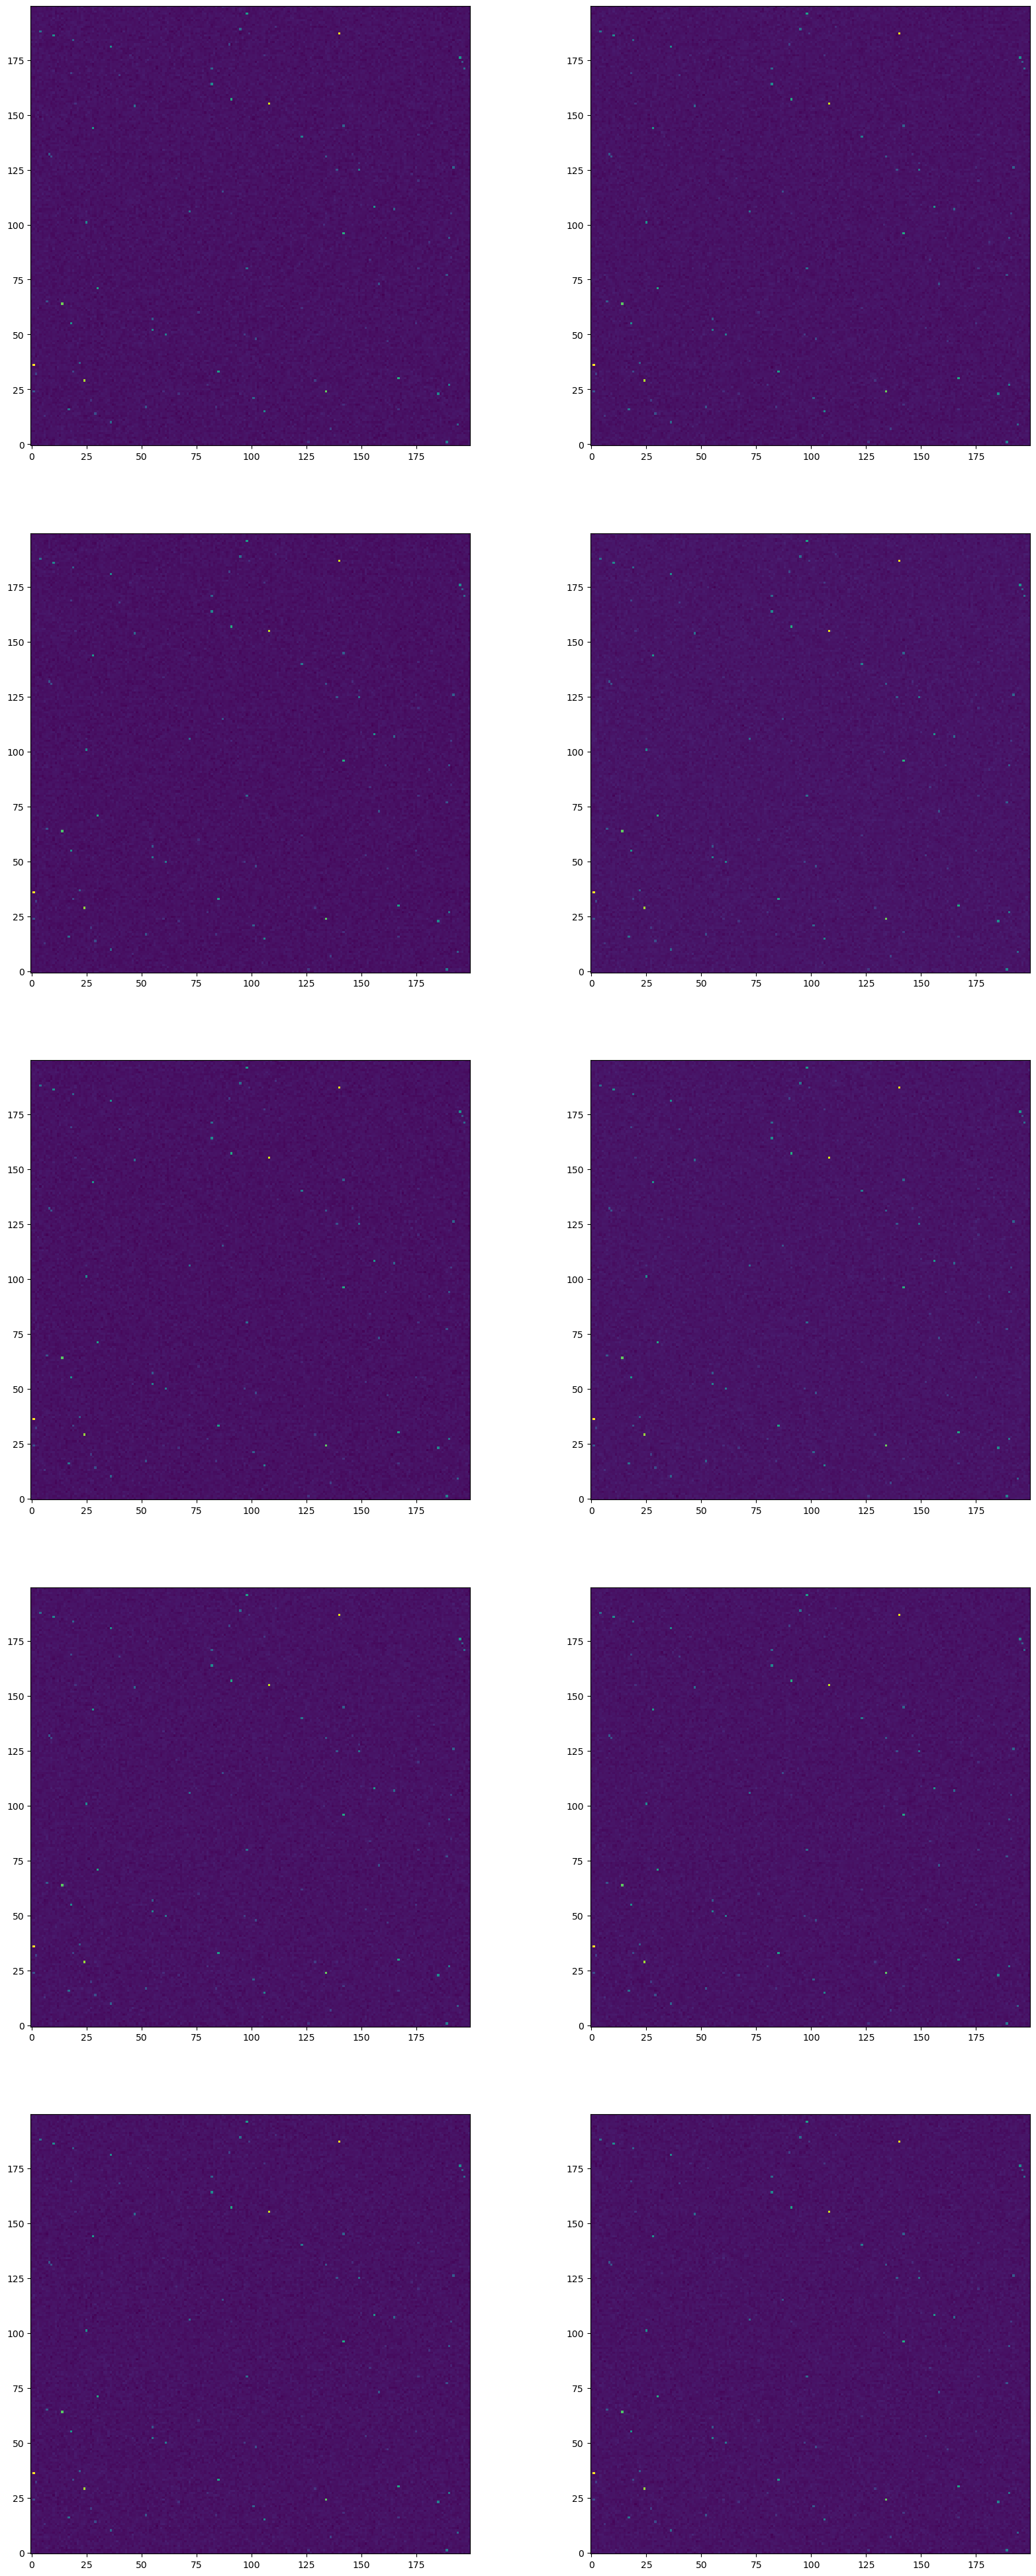

In [125]:
#plot the image_stack, total 10 images
fig, x_s = plt.subplots(5, 2, figsize=(20, 50))
for x, image in zip(x_s.flatten(), np.swapaxes(np.swapaxes(imagestack_data, 0, 2), 1, 2)):
    x.imshow(image, origin='lower')

#the color bar is same as above,
#which is increasing from the violet to blue to green then to yellow

With the primary observation, we find the ten graphs are in a very similar condition. Then, we can conclude that the background is constant, and it is independent with time. Meanwhile, it is consistent spatially.
To reach our goal that looking for the faintest stars among ten images, we should average the total ten pictures. Then, without the outliers at a sensitivity threshold, the spread of the background will decrease, and then we will be able to find the faint stars from the background.

part 3) hunt for faint star

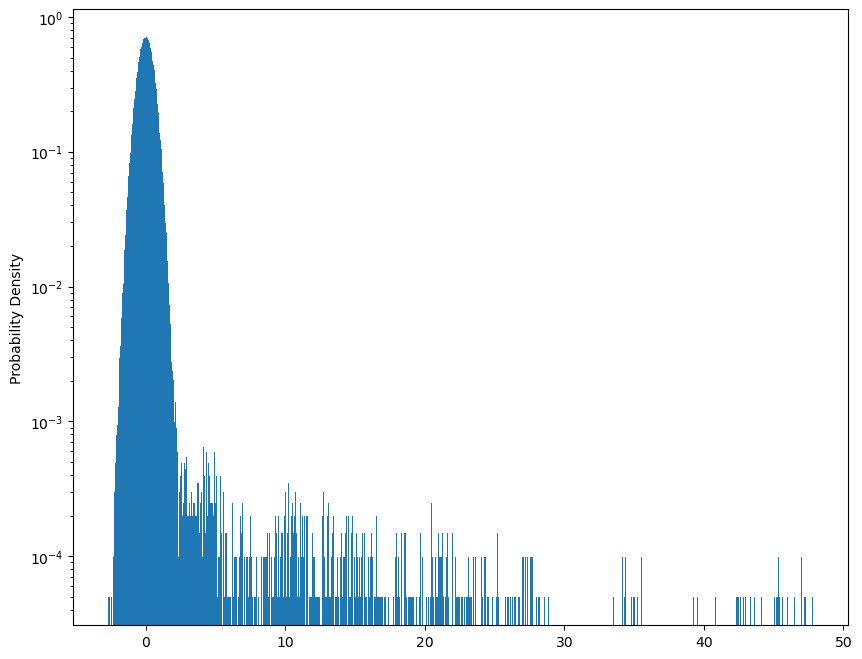

In [126]:
# the histogram of the images_stake with log in y-values
stack_data = imagestack_data[:, :, :].flatten()
plt.hist(stack_data, bins=1000, density=True)
plt.ylabel('Probability Density')
plt.yscale('log')
plt.show()

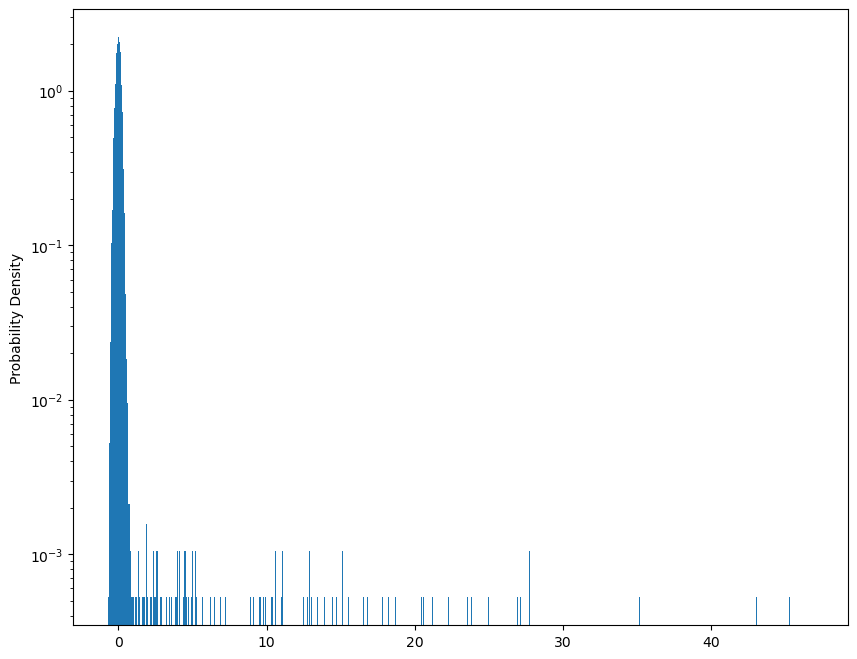

In [127]:
#then we continue to find out the histogram of average
stack_avg = np.mean(imagestack_data,axis=2)
plt.hist(stack_avg.flatten(), bins=1000, density=True)
plt.ylabel('Probability Density')
plt.yscale('log')
plt.show()

We find the main data fits the Guassian distribution without some outliers. Then, we want to find out the suitable valus of the Guassian distribution.

In [128]:
stack_relevant = stack_avg[stack_avg < 1]
mean = np.mean(stack_relevant)
sd = np.std(stack_relevant)

In [129]:
mean

-0.0001292660742716416

In [130]:
sd

0.1778348962220202

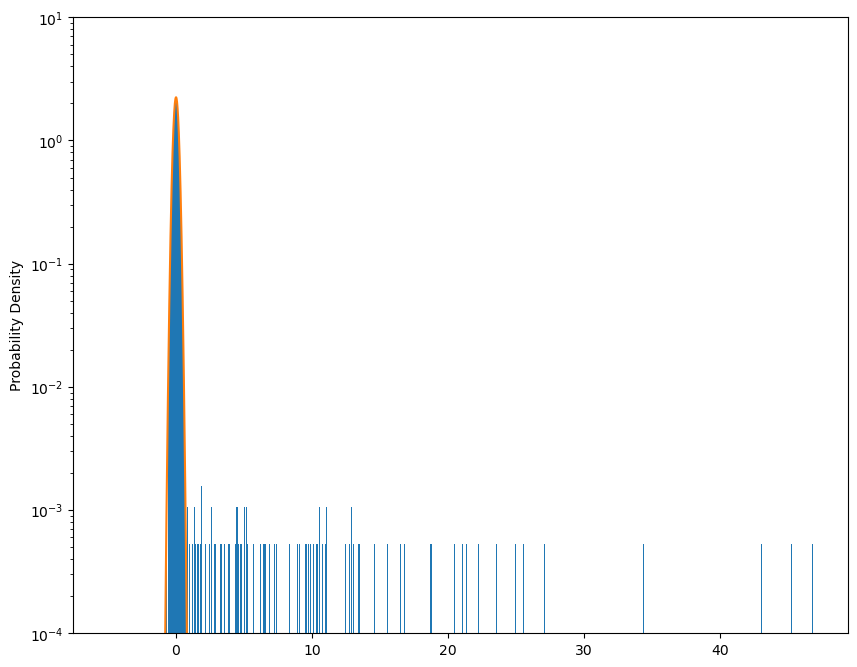

In [131]:
#check the Guassian distribution
stack_avg = np.mean(imagestack_data,axis=2)
plt.hist(stack_avg.flatten(), bins=1000, density=True)
x = np.linspace(-5,5,1000)
plt.plot(x, stats.norm.pdf(x, loc=mean, scale=sd))
plt.ylabel('Probability Density')
plt.yscale('log')
plt.ylim(1e-4, 10)
plt.show()

Without considering the outliers, we find the mean of the Guassian distribution is about -0.000129, and the standard derviation is 0.177835. Here, we can use the data to calculate the threshold of 5 $\sigma$, 8 $\sigma$

In [132]:
#5 sigma
threshold = stats.norm(mean, sd).ppf(stats.norm.cdf(5))
threshold

0.8890452150305256

In [133]:
#8 sigma
threshold2 = stats.norm(mean, sd).ppf(stats.norm.cdf(8))
threshold2

1.4210514580624118

These two values will be exactly the answers to the sensitivity hereshold with 5 sigma or 8 sigma. 

Last, we will show the stars within the restriction between 5 sigma and 6 sigma

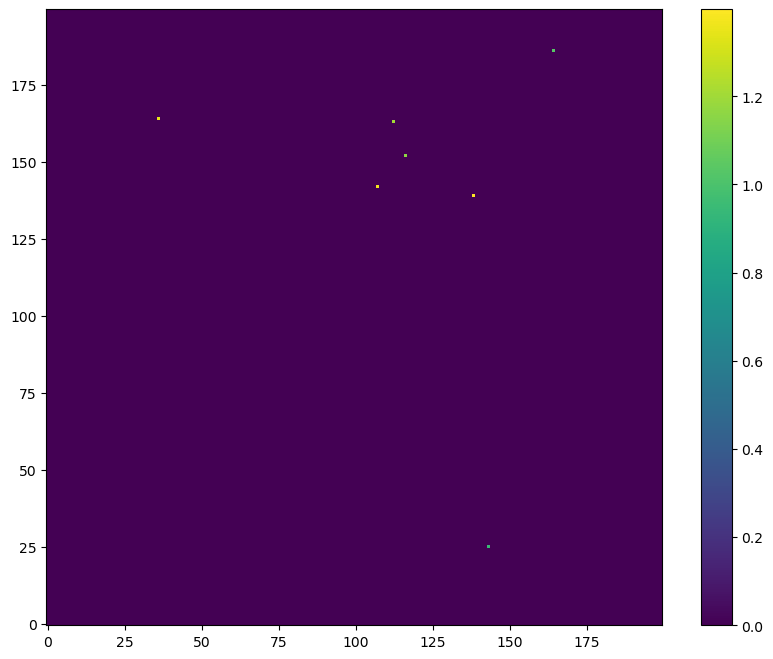

In [134]:
value = (stack_avg > threshold) & (stack_avg < threshold2)
plt.imshow(stack_avg * value, origin='lower')
plt.colorbar()

From the graph above, we find there are seven stars within the restriction. Meanwhile, we can determine the brightness from the colors with the aid of the color bar at right.

part 4):
Although we are using the same data, we have different pdf here. Because the purposes are different, and we need different ways to reach the goal. <br />
For me, I want to find out the faint stars. Then, for pdf(), I will sum up or average the total ten graphs. <br />
For my partner, he wants to find out the transient. Then, for pdf(), he needs to find out the data with the largest standard deviation from the average values.
